# Credit Markets
## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

# Smooth Credit Models: Nelson-Siegel and extensions

- 1\. SOFR OIS discount curve calibration / Prepare test corporate bond
  - a. SOFR curve calibration (via Bootstrapping)
  - b. Create Fixed Rate corporate bond (for testing)
- 2\. Pricing risky bonds in Custom Hazard Rate Model (with Credit Default Risk)
  - a. Create and Display the Custom Credit Curve
  - b. Price Risky Bond on Custom Credit Curve (with Credit Risk)
- 3\. Smooth parametric yield and hazard rate curves: Nelson-Siegel + extensions
  - a. Nelson Siegel basis functions
  - b. Plot Basis Functions for Nelson-Siegel + extensions
  - c. Constructing smooth Nelson-Siegel hazard rate / survival probability curves
  - d. Pricing risky bonds in Nelson-Siegel model (with Credit Risk) 


In [28]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

-----------------------------------------------------------
# 1. SOFR OIS discount curve calibration / Prepare test corporate bond

## a. SOFR curve calibration (via Bootstrapping)

Overnight Index Swap contract is an interest rate swap contract exchanging and overnight index interest rate (e.g. Fed Funds, SOFR, LIBOR) for a fixed interest rate until the contract maturity. The fixed rate is set at a rate agreed upon by both parties. The floating leg portion of the swap is compounded and paid at reset dates. 

In [29]:
# Set the static valuation date: 2024-12-13
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# calendar
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

# settle_days
settle_days = 1

# SOFR OIS swap tenors: 1Y, 2Y, 3Y, 5Y 7Y, 10Y, 20Y and 30Y
SOFR_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10, 20, 30]]
               
# SOFR OIS swap rates (as of 2024-12-13)
SOFR_rates = [4.81, 4.11, 3.73, 3.38, 3.32, 3.26, 3.20, 3.02]

SOFR_OIS_swap_helpers = []
for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):
    SOFR_OIS_swap_helpers.append(ql.OISRateHelper(settle_days, SOFR_tenor, ql.QuoteHandle(ql.SimpleQuote(SOFR_rate/100)), ql.Sofr()))

# Create SOFR yield curve
sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, SOFR_OIS_swap_helpers, ql.Actual360())
sofr_yield_curve.enableExtrapolation()
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

print(sofr_yield_curve.referenceDate())


December 16th, 2024


# b. Prepare Fixed Rate corporate bond (for testing)

In [30]:
# Create fixed rate corporate bond

issue_date = ql.Date(13, 12, 2024)
maturity_date = ql.Date(13, 12, 2029)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end)

# Corp Bonds specs
day_count = ql.Thirty360(ql.Thirty360.USA)
settlement_days = 1
coupon_rate = 0.04  # 4% fixed coupon
coupons = [coupon_rate]
payment_convention = ql.Unadjusted

# Construct the FixedRateBond
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count,
    payment_convention)

x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)


           CashFlowDate  CashFlowAmount
0       June 13th, 2025             2.0
1   December 13th, 2025             2.0
2       June 13th, 2026             2.0
3   December 13th, 2026             2.0
4       June 13th, 2027             2.0
5   December 13th, 2027             2.0
6       June 13th, 2028             2.0
7   December 13th, 2028             2.0
8       June 13th, 2029             2.0
9   December 13th, 2029             2.0
10  December 13th, 2029           100.0


In [31]:
# Compute risk-free bond price and yield

risk_free_bond_engine = ql.DiscountingBondEngine(sofr_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
risk_free_bond_price = fixed_rate_bond.cleanPrice()
risk_free_bond_yield = fixed_rate_bond.bondYield(risk_free_bond_price, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100

print('risk_free_bond_price:', risk_free_bond_price)
print('risk_free_bond_yield:', risk_free_bond_yield)


risk_free_bond_price: 102.69522423380708
risk_free_bond_yield: 3.4081877660751347


-----------------------------------------------------------
# 2. Pricing risky bonds in Custom Hazard Rate Model (with Credit Default Risk)
## a. Create and Display the Custom Credit Curve

Text(0.5, 0, 'Date')

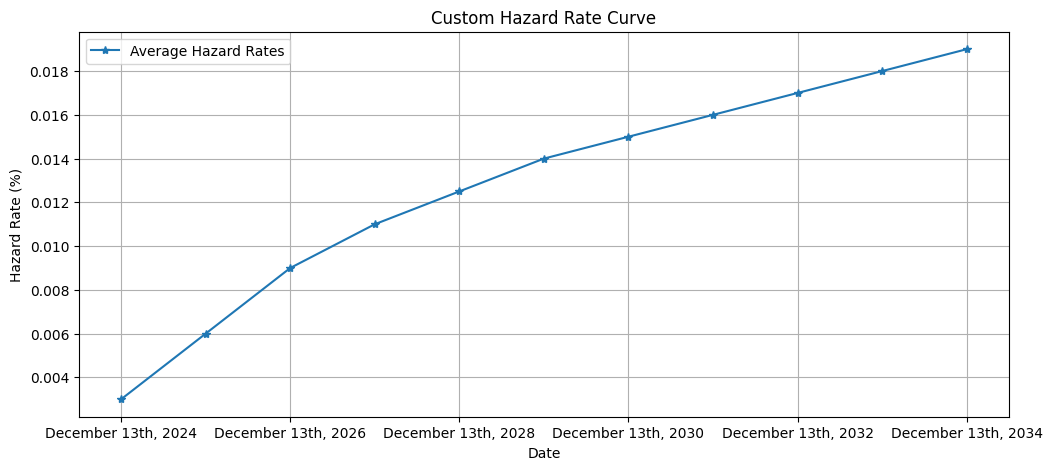

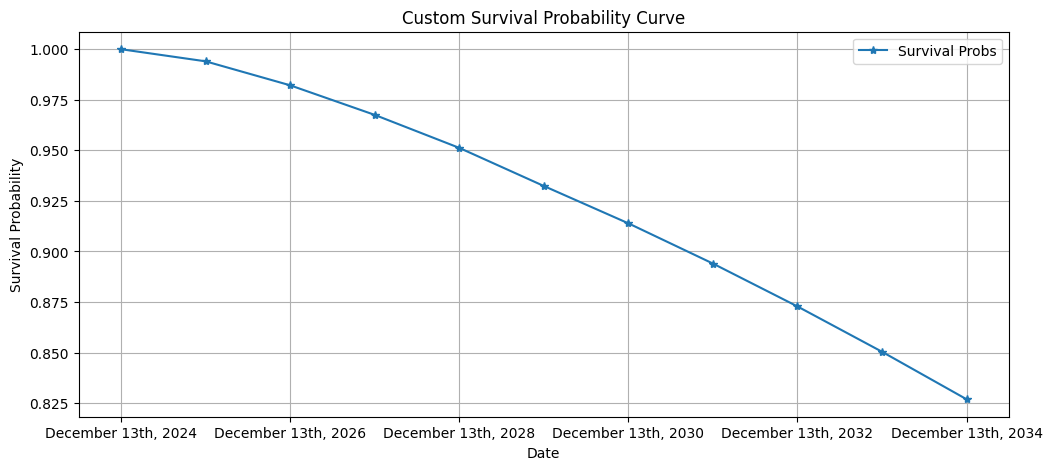

In [32]:
# 1. Create custom survival probability curve
custom_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(11)]
custom_average_hazard_rates = [0.0030, 0.0060, 0.0090, 0.0110, 0.0125, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180, 0.0190]
custom_surv_prob_levels = [np.exp(-T * custom_average_hazard_rates[T]) for T in range(11)]
# custom_surv_prob_levels = [1.0, 0.9950, 0.9860, 0.9733, 0.9569, 0.9370, 0.9166, 0.8940, 0.8728, 0.8504, 0.8269]

# custom_surv_prob_curve
custom_surv_prob_curve = ql.SurvivalProbabilityCurve(custom_surv_prob_dates, custom_surv_prob_levels, ql.Actual360(), ql.TARGET())
custom_surv_prob_curve.enableExtrapolation()
custom_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(custom_surv_prob_curve)

# 2. Display custom credit curve
custom_surv_prob_df = pd.DataFrame(data={'Date': custom_surv_prob_dates,
                                          'Average Hazard Rates': custom_average_hazard_rates,
                                          'Survival Probs': custom_surv_prob_levels})

plt = custom_surv_prob_df.plot(x='Date', y='Average Hazard Rates', grid=True, style='*-', title='Custom Hazard Rate Curve', figsize=(12,5))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = custom_surv_prob_df.plot(x='Date', y='Survival Probs', grid=True, style='*-', title='Custom Survival Probability Curve', figsize=(12,5))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')

## b. Price Risky Bond on Custom Credit Curve (with Credit Risk) 

In [33]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# custom_curve_risky_bond_engine
custom_curve_risky_bond_engine = ql.RiskyBondEngine(custom_surv_prob_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(custom_curve_risky_bond_engine)

# 3. Price risky bond on custom survival probability curve
risky_bond_price = fixed_rate_bond.cleanPrice()
risky_bond_yield = fixed_rate_bond.bondYield(risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('risky_bond_price:', risky_bond_price)
print('risky_bond_yield:', risky_bond_yield)

# Compute the credit I-Spread, relative to risk-free bond (SOFR curve)
risky_bond_credit_ispread_bps = (risky_bond_yield - risk_free_bond_yield) * 100
print('risky_bond_ispread_bps:', risky_bond_credit_ispread_bps)

# Calc z-spread
risky_bond_zspread_bps = ql.BondFunctions.zSpread(fixed_rate_bond, risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('risky_bond_zspread_bps:', risky_bond_zspread_bps)



risky_bond_price: 98.8550662711316
risky_bond_yield: 4.256946402230856
risky_bond_ispread_bps: 84.87586361557211
risky_bond_zspread_bps: 83.56240180627945


# 3. Smooth parametric yield and hazard rate curves: Nelson-Siegel + extensions
## a. Nelson Siegel basis functions

In [34]:
# nelson_siegel curve shape: Nelson-Siegel
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    
    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

# nelson_siegel_extended curve shape: Nelson-Siegel-Svensson
def nelson_siegel_extended(params, maturity):

    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1    
    
    if(params[5] != 0):
        if(maturity > 0):
            slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])
        else:
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value


## b. Plot Basis Functions for Nelson-Siegel + extensions

   TTM  Level     Slope  Curvature_1  Curvature_2
0    0    1.0  1.000000     0.000000     0.000000
1    1    1.0  0.786939     0.360816     0.046788
2    2    1.0  0.632121     0.528482     0.087615
3    3    1.0  0.517913     0.589566     0.123121
4    4    1.0  0.432332     0.593994     0.153880


Text(0.5, 0, 'Time to maturity (years)')

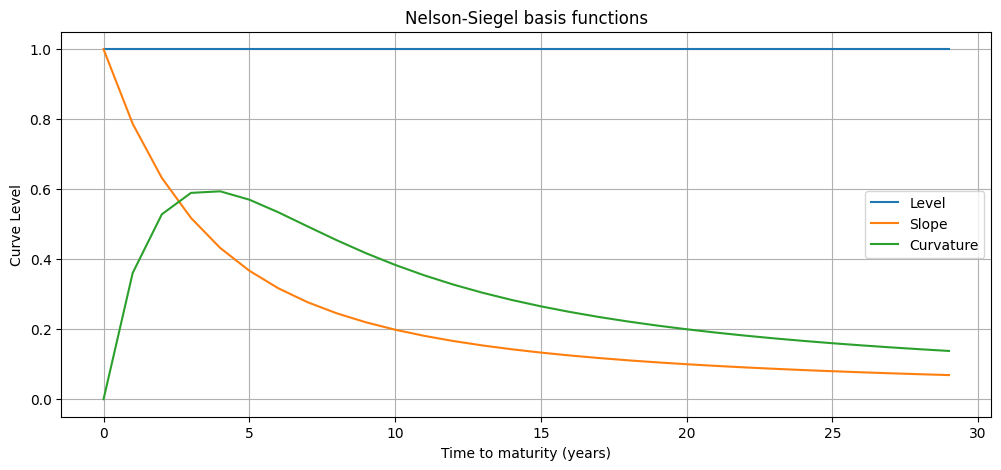

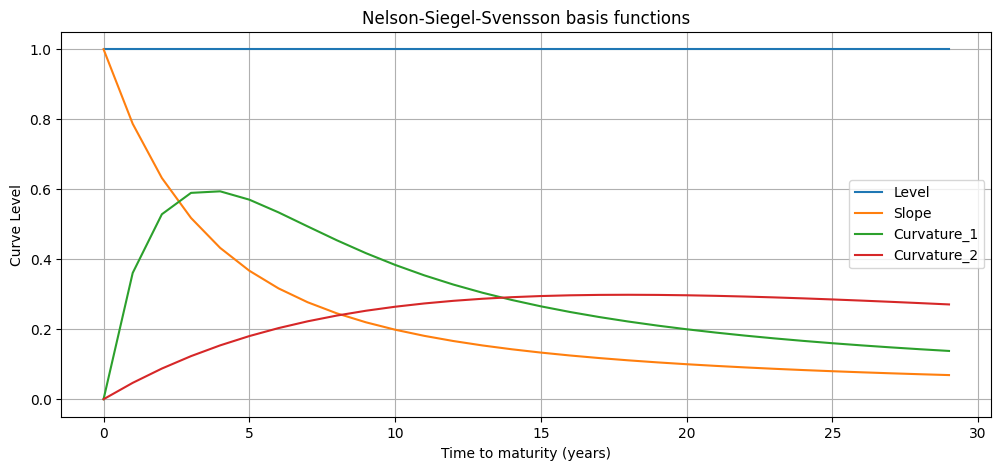

In [35]:

curve_shapes_df = pd.DataFrame([T, nelson_siegel([1, 0, 0, 2], T), 
                                 nelson_siegel([0, 1, 0, 2], T), 
                                 nelson_siegel([0, 0, 2, 2], T)] for T in range(0,30,1))
curve_shapes_df.columns = ['TTM', 'Level', 'Slope', 'Curvature']

curve_shapes_df2 = pd.DataFrame([T, nelson_siegel_extended([1, 0, 0, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 1, 0, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 0, 2, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 0, 0, 2, 1, 10], T)] for T in range(0,30,1))
curve_shapes_df2.columns = ['TTM', 'Level', 'Slope', 'Curvature_1', 'Curvature_2']

print(curve_shapes_df2.head())

plt = curve_shapes_df.plot(x='TTM', y=['Level', 'Slope', 'Curvature'], grid=True, style='-', title='Nelson-Siegel basis functions', figsize=(12,5))
plt.set_ylabel('Curve Level')
plt.set_xlabel('Time to maturity (years)')

plt = curve_shapes_df2.plot(x='TTM', y=['Level', 'Slope', 'Curvature_1', 'Curvature_2'], grid=True, style='-', title='Nelson-Siegel-Svensson basis functions', figsize=(12,5))
plt.set_ylabel('Curve Level')
plt.set_xlabel('Time to maturity (years)')


## c. Constructing smooth Nelson-Siegel hazard rate / survival probability curves

,Dates,Average Hazard Rates,Survival Probs
0,2024-12-13,0.020000,1.000000
1,2025-12-13,0.021950,0.978289
2,2026-12-13,0.023415,0.954250
3,2027-12-13,0.024526,0.929063
4,2028-12-13,0.025380,0.903464


Text(0.5, 0, 'Maturity')

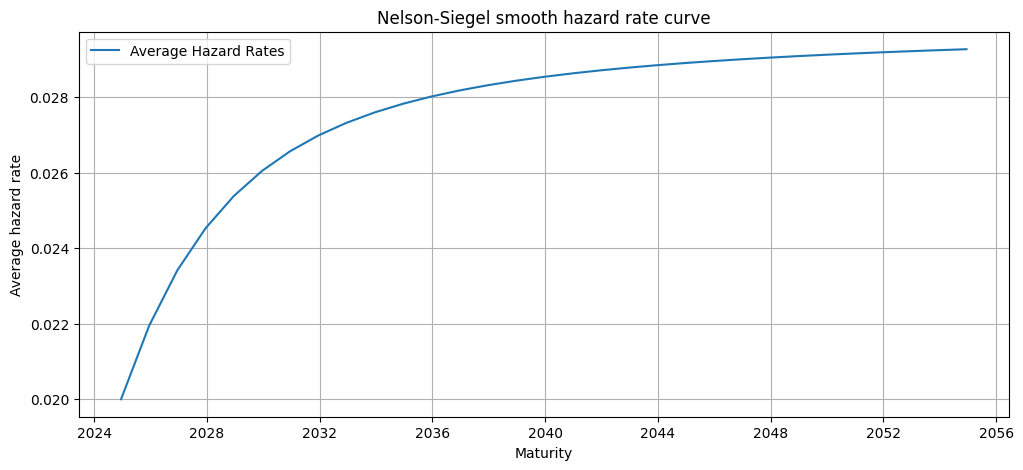

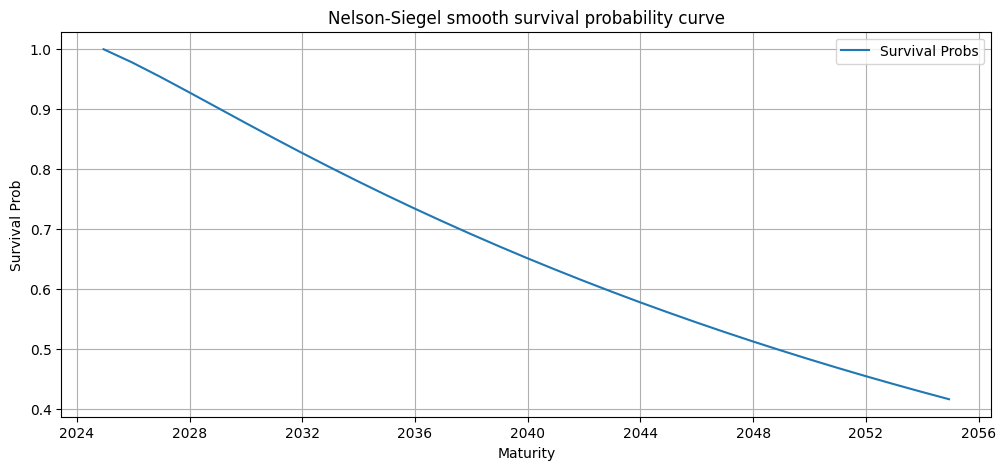

In [42]:
# nelson_siegel_params = [theta1, theta2, theta3, lambda] = [long term level, short - long slope, curvature, lambda]
nelson_siegel_params = [0.0300, -0.0100, -0.0010, 2]

nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
nelson_siegel_surv_prob_dates_pd = [d.to_date() for d in nelson_siegel_surv_prob_dates]
nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

# nelson_siegel_surv_prob_curve
nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
nelson_siegel_credit_curve.enableExtrapolation()
nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)

nelson_siegel_surv_prob_df = pd.DataFrame(data={'Dates': nelson_siegel_surv_prob_dates_pd,
                                          'Average Hazard Rates': nelson_siegel_average_hazard_rates,
                                          'Survival Probs': nelson_siegel_surv_prob_levels})
display(nelson_siegel_surv_prob_df.head())

plt = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Average Hazard Rates'], grid=True, style='-', title='Nelson-Siegel smooth hazard rate curve', figsize=(12,5))
plt.set_ylabel('Average hazard rate')
plt.set_xlabel('Maturity')

plt = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Survival Probs'], grid=True, style='-', title='Nelson-Siegel smooth survival probability curve', figsize=(12,5))
plt.set_ylabel('Survival Prob')
plt.set_xlabel('Maturity')



## d. Pricing risky bonds in Nelson-Siegel model (with Credit Risk)

In [44]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# nelson_siegel_risky_bond_engine
nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)

# Price risky bond using Nelson-Siegel survival probability curve
nelson_siegel_risky_bond_price = fixed_rate_bond.cleanPrice()
nelson_siegel_risky_bond_yield = fixed_rate_bond.bondYield(nelson_siegel_risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('nelson_siegel_surv_prob_risky_bond_price:', round(nelson_siegel_risky_bond_price, 3))
print('nelson_siegel_surv_prob_risky_bond_yield:', round(nelson_siegel_risky_bond_yield, 3))

# Compute the credit I-Spread (relative to risk-free SOFR bond)
nelson_siegel_risky_bond_credit_ispread = (nelson_siegel_risky_bond_yield - risk_free_bond_yield) * 1e2
print('nelson_siegel_risky_bond_ispread:', round(nelson_siegel_risky_bond_credit_ispread, 3))

# Compute z-spread
nelson_siegel_risky_bond_zspread = ql.BondFunctions.zSpread(fixed_rate_bond, nelson_siegel_risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('nelson_siegel_risky_bond_zspread:', round(nelson_siegel_risky_bond_zspread, 3))



nelson_siegel_surv_prob_risky_bond_price: 95.646
nelson_siegel_surv_prob_risky_bond_yield: 4.996
nelson_siegel_risky_bond_ispread: 158.814
nelson_siegel_risky_bond_zspread: 156.351
